In [1]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from tqdm.auto import tqdm

In [2]:
from src.conditional_ngram_models import BigramSpellCorrector, TrigramSpellCorrector
from src.ngram_models import *

## The Dataset

In [3]:
nltk.download('movie_reviews')
nltk.download('gutenberg')

[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/dimits/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
[nltk_data] Downloading package gutenberg to /home/dimits/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

In [4]:
movie_corpus = nltk.corpus.movie_reviews.fileids()                                 #Get all the files

In [5]:
gutenberg_corpus = nltk.corpus.gutenberg.fileids()                                 #Get all the files
gutenberg_corpus

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [6]:
filtered_gutenberg_corpus = [                        #We wish to keep only these from gutenberg corpus
    'austen-emma.txt', 
    'austen-persuasion.txt', 
    'austen-sense.txt', 
    'burgess-busterbrown.txt', 
    'carroll-alice.txt', 
    'chesterton-ball.txt',
    'chesterton-brown.txt' ]

In [7]:
combined_text = ""   

print("Loading Gutenberg corpus...")
for file_id in tqdm(filtered_gutenberg_corpus):                                        # Combine the text from all files
    combined_text += nltk.corpus.gutenberg.raw(file_id)

print("Loading Movie Review corpus...")
for file_id in tqdm(movie_corpus):
    combined_text += nltk.corpus.movie_reviews.raw(file_id)
    
print(combined_text[:500])

[Emma by Jane Austen 1816]

VOLUME I

CHAPTER I


Emma Woodhouse, handsome, clever, and rich, with a comfortable home
and happy disposition, seemed to unite some of the best blessings
of existence; and had lived nearly twenty-one years in the world
with very little to distress or vex her.

She was the youngest of the two daughters of a most affectionate,
indulgent father; and had, in consequence of her sister's marriage,
been mistress of his house from a very early period.  Her mother
had died t


In [8]:
def tokenize_sentences(text):
    sentences = nltk.sent_tokenize(''.join(text))                  #Get the sentences
    return sentences     

In [9]:
sentences = tokenize_sentences(combined_text) 
print(len(sentences))    
print(sentences[2])  
print(sentences[57649])

98298
Her mother
had died too long ago for her to have more than an indistinct
remembrance of her caresses; and her place had been supplied
by an excellent woman as governess, who had fallen little short
of a mother in affection.
meanwhile , marc's spoiled ( hetero ) female roommate , cynthia ( mara hobel ) , spends her days lying about their apartment and harrassing magazine editor tina brown .


In [10]:
def tokenize_words(text):
    words = nltk.word_tokenize(text)
    return words

In [11]:
words = tokenize_words(combined_text)
print(len(words))
print(words[3])
print(words[-2])

2190843
Jane
be


In [12]:
words_list = []                                    #list of all the words of sentences
print("Getting words from source texts...")
for f in tqdm(sentences):
    words_list.append(tokenize_words(f))                   

Getting words from source texts...


  0%|          | 0/98298 [00:00<?, ?it/s]

In [13]:
len(words_list)

98298

In [14]:
for word in words_list[1]:                     # all the words of the second sentence
    print(word) 

She
was
the
youngest
of
the
two
daughters
of
a
most
affectionate
,
indulgent
father
;
and
had
,
in
consequence
of
her
sister
's
marriage
,
been
mistress
of
his
house
from
a
very
early
period
.


In [15]:
import random
import math


random.shuffle(words_list)
train_len = math.floor(0.6 * len(words_list))                      #Training set length(60%)
dev_len = math.floor(0.2 * len(words_list))                        #Development set length (20%)
test_len = math.floor(0.2 * len(words_list))                       #Test set length (20%)

training_set = []
development_set = []
test_set = []

for content in words_list[0:train_len]:
    training_set.append(content)
    
for content in words_list[train_len: train_len + dev_len]:
    development_set.append(content)

for content in words_list[train_len + dev_len:]:
    test_set.append(content)

In [16]:
import itertools
from collections import Counter

from nltk.util import ngrams


def _calc_ngrams(all_corpus: list[str], ngram: int) -> Counter:
    """
    Process a tokenized sentence into a list of ngrams.
    :param all_corpus: a list of all the corpus words
    :param ngram: whether the ngrams will be unigrams, bigrams etc
    :return: the counter of either unigram, bigram or trigram
    """
    unigram_counter = Counter()
    bigram_counter = Counter()
    trigram_counter = Counter()
     
    

    if ngram == 1 :
        for sentence in all_corpus:
             grams = [gram for gram in ngrams(sentence, ngram, pad_left=True, pad_right=True,
                                    left_pad_symbol=START_TOKEN, right_pad_symbol=END_TOKEN)]
             unigram_counter.update(grams)
        return unigram_counter
        
    elif ngram == 2:
        for sentence in all_corpus:
             grams = [gram for gram in ngrams(sentence, ngram, pad_left=True, pad_right=True,
                                    left_pad_symbol=START_TOKEN, right_pad_symbol=END_TOKEN)]
             bigram_counter.update(grams)
        return bigram_counter
        
    elif ngram == 3:
        for sentence in all_corpus:
             grams = [gram for gram in ngrams(sentence, ngram, pad_left=True, pad_right=True,
                                    left_pad_symbol=START_TOKEN, right_pad_symbol=END_TOKEN)]
             trigram_counter.update(grams)
        return trigram_counter
        
    return 0

In [17]:
def replace_OOV_words_train(all_corpus):
    unigram_counter = _calc_ngrams(all_corpus,1)
    OOV_words = {}

    for k, v in unigram_counter.items():
        if v < 10:
            key = k[0]
            # README: Use the symbol UNKOWN_TOKEN else the model will think it's a word
            OOV_words[key] = UNKNOWN_TOKEN                 #set the word to "UNK"

    replaced_corpus = []                          #the original corpus having the OOV words replaced by 'UNK'
    for sentence in all_corpus:
        clean_sentence = []
    
        for word in sentence:
            clean_sentence.append(OOV_words.get(word, word))
    
        replaced_corpus.append(clean_sentence)


    vocabulary = []

    for key in unigram_counter.keys():        #Iterate the unigram counter
        word = key[0]                         #get the word
        if word not in OOV_words:
            vocabulary.append(word)

    vocabulary = set(vocabulary)              #Keep unique words
    return vocabulary, replaced_corpus, OOV_words

In [18]:
def replace_OOV_words_test(all_corpus, vocabulary, oov_words):
    
    replaced_corpus = []
    for sentence in all_corpus:
        updated_sent = []

        for word in sentence:
            if (word not in vocabulary) or (word in oov_words):
                updated_sent.append(UNKNOWN_TOKEN)
            else:
                updated_sent.append(word)
                
    replaced_corpus.append(updated_sent)
    return replaced_corpus   

In [19]:
vocabulary, train_corpus, OOV_words = replace_OOV_words_train(training_set)
development_set = replace_OOV_words_test(development_set, vocabulary, OOV_words)
test_set = replace_OOV_words_test(test_set, vocabulary, OOV_words)

In [20]:
vocab_len = len(vocabulary)
print ("Vocabulary length: ", vocab_len)

print("Unigram's 20 most common words:")
unigram_top_20 = _calc_ngrams(train_corpus, 1).most_common(20)
for gram in unigram_top_20:
    print(gram)

print("\n")
print("Bigram's 20 most common words:")
bigram_top_20 = _calc_ngrams(train_corpus,2).most_common(20)
for gram in bigram_top_20:
    print(gram)


print("\n")
print("Trigram's 20 most common words:")
trigram_top_20 = _calc_ngrams(train_corpus,3).most_common(20)
for gram in trigram_top_20:
    print(gram)

Vocabulary length:  8222
Unigram's 20 most common words:
(('<UNK>',), 86740)
((',',), 71638)
(('the',), 59614)
(('.',), 53028)
(('and',), 31089)
(('of',), 29915)
(('a',), 29797)
(('to',), 28659)
(('in',), 18039)
(('is',), 17871)
(('``',), 14671)
(('it',), 13875)
(('that',), 13302)
(("'s",), 12648)
(('as',), 9777)
(('with',), 9093)
(('he',), 8773)
(('his',), 8549)
(('for',), 8446)
(('was',), 8076)


Bigram's 20 most common words:
(('.', '<end>'), 49333)
(('<UNK>', ','), 9994)
((',', 'and'), 9364)
(('the', '<UNK>'), 7895)
(('<UNK>', '<UNK>'), 7486)
(('<UNK>', '.'), 6817)
(('of', 'the'), 6760)
(('<start>', 'the'), 4848)
(('a', '<UNK>'), 4779)
(('in', 'the'), 4628)
((',', '<UNK>'), 4153)
((',', 'but'), 3856)
(('and', '<UNK>'), 3707)
(('<UNK>', 'and'), 3466)
(('<UNK>', 'of'), 3456)
(('<start>', '<UNK>'), 3393)
((',', 'the'), 3238)
(('<start>', '``'), 3086)
(("''", '<end>'), 3069)
(('of', '<UNK>'), 2816)


Trigram's 20 most common words:
(('.', '<end>', '<end>'), 49333)
(('<UNK>', '.', '<end

In [21]:
from nltk.tokenize import sent_tokenize, TweetTokenizer


UNK_sentences = [sent_tokenize(' '.join(sentence)) for sentence in train_corpus]       #get the sentences that include UNK values
tweet_wt = TweetTokenizer()
tokenized = [tweet_wt.tokenize(' '.join(sentence)) for sentence in UNK_sentences[:50]]  # Get the first 50 sentences

##  Calculate bi-gram probability

### $ P(w_2|w_1) = \frac{C(w_1,w_2) + \alpha}{C(w_1) + \alpha \cdot|V|} $

* $ C(w_1,w_2) $ : bigram count
* $ C(w_1) $ : unigram count
* $ 0 \leq\alpha \leq1 $ :  smoothing hyper-parameter
* |V|: vocabulary size

## Bi-gram LM Cross entropy & perplexity

* $ CrossEntropy = -\frac{1}{N}\sum^{bigrams}{log_2(P(w_2|w_1))} $
 * N: Number of bigrams
* $ Perplexity = 2^{H(p)} $

## Tri-gram LM Cross entropy & perplexity

### $ P(w_3|w_1,w_2) = \frac{C(w_1,w_2,w_3) + \alpha}{C(w_1,w_2) + \alpha \cdot |V|} $

* $ C(w_1,w_2,w_3) $ : trigram count
* $ C(w_1,w_2) $ : bigram count
* $ 0 \leq\alpha \leq1 $ :  smoothing hyper-parameter
* |V|: vocabulary size

In [22]:
def cross_entropy(model: BaseNgramModel, dataset: list[list[str]]) -> float:
    """
    Calculate the cross-entropy of a language model on a given dataset.
    
    Cross-entropy measures how well the language model predicts the given dataset.
    Lower cross-entropy indicates better model performance.
    
    :param model: The n-gram language model for which cross-entropy is calculated.
    :param dataset: The dataset as a list of tokenized sentences, where each sentence is a list of strings.
    :return: The cross-entropy score as a float.
             Lower values indicate better performance in predicting the dataset.
    """
    # since la place smoothing is only involved during inference
    # we don't need to refit the model
    sum_prob = 0
    word_count = 0
    
    for sentence in dataset:       
        # since this is a full sentence we manually append the end token
        sentence += [END_TOKEN]
        
        # take into account only the END_TOKEN since START token probs are not computed
        word_count += len(sentence)
        
        # get sentence probability
        sum_prob += bi_model.sentence_proba(sentence) 
    
    # do we need to logarithmize this again?
    return - sum_prob / word_count


def perplexity(cross_entropy: float) -> float:
    """
    Calculate perplexity from cross-entropy.
    
    Perplexity is a measure of how well the language model predicts the given dataset.
    A model with a perplexity of k, has approximately a 1/k chance of correctly predicting the next word in a sentence.
    
    :param cross_entropy: The cross-entropy score calculated for a language model on a dataset.
    :return: The perplexity score as a float.
             Lower values indicate better performance in predicting the dataset.
    """
    return 2**cross_entropy

In [23]:
def plot_alpha_vs_entropy(alpha_values, entropy, best_index):
    plt.figure(figsize=(10, 6))
    plt.plot(alpha_values, entropy, marker='o', linestyle='-', color='b')
    plt.title('Alpha vs Entropy')
    plt.xlabel('Alpha Values')
    plt.ylabel('Cross Entropy')
    plt.grid(True)
    
    # Highlight the best alpha value
    plt.scatter(alpha_values[best_index], entropy[best_index], color='r', marker='x', label='Best Alpha')
    
    plt.legend()
    plt.show()

In [24]:
def ngram_model_alpha_search(fitted_model: BaseNgramModel, 
                             alpha_values: np.ndarray, 
                             validation_dataset: list[list[str]]) -> float:
    entropy_arr = np.full_like(alpha_values, np.inf)
    
    print("Beginning grid search for n-gram model...")
    for i in tqdm(range(len(alpha_values))):
        fitted_model.alpha = alpha_values[i]
        entropy_arr[i] = cross_entropy(fitted_model, validation_dataset)
        
       
    best_index = np.argmin(entropy_arr)
    plot_alpha_vs_entropy(alpha_values,entropy_arr, best_index) 
    return alpha_values[best_index]

Beginning grid search for n-gram model...


  0%|          | 0/1000 [00:00<?, ?it/s]

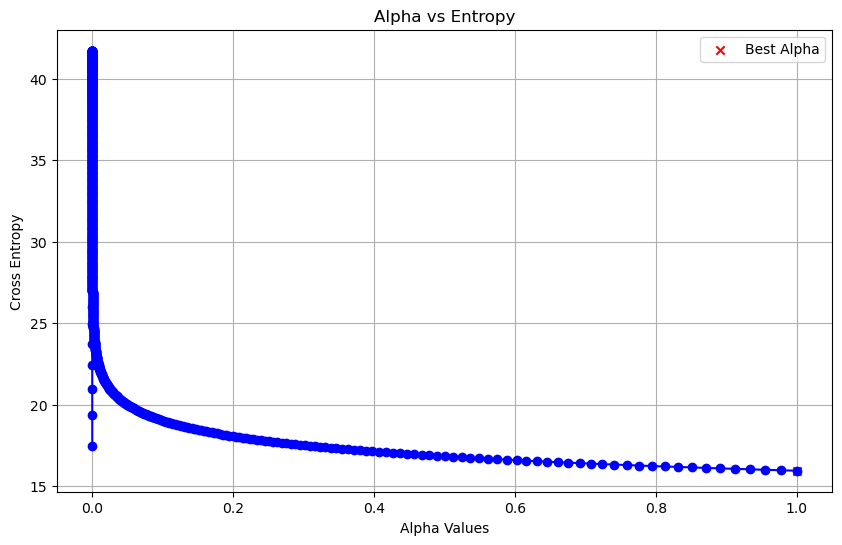

Optimal alpha (bigram model):  1.0


In [25]:
bi_model = BigramModel(alpha=0.001)
bi_model.fit(train_corpus)

bi_opt_alpha = ngram_model_alpha_search(bi_model, np.logspace(-10, 0, 1000), development_set)
print("Optimal alpha (bigram model): ", bi_opt_alpha)

Beginning grid search for n-gram model...


  0%|          | 0/1000 [00:00<?, ?it/s]

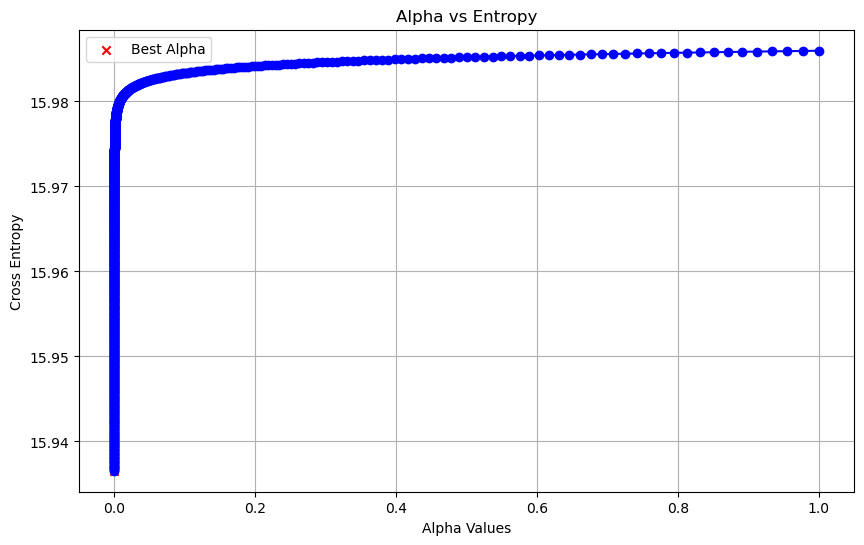

Optimal alpha (trigram model):  1e-10


In [26]:
tri_model = TrigramModel(alpha=0.001)
tri_model.fit(train_corpus)

tri_opt_alpha = ngram_model_alpha_search(tri_model, np.logspace(-10, 0, 1000), development_set)
print("Optimal alpha (trigram model): ", tri_opt_alpha)

Beginning grid search for n-gram model...


  0%|          | 0/1000 [00:00<?, ?it/s]

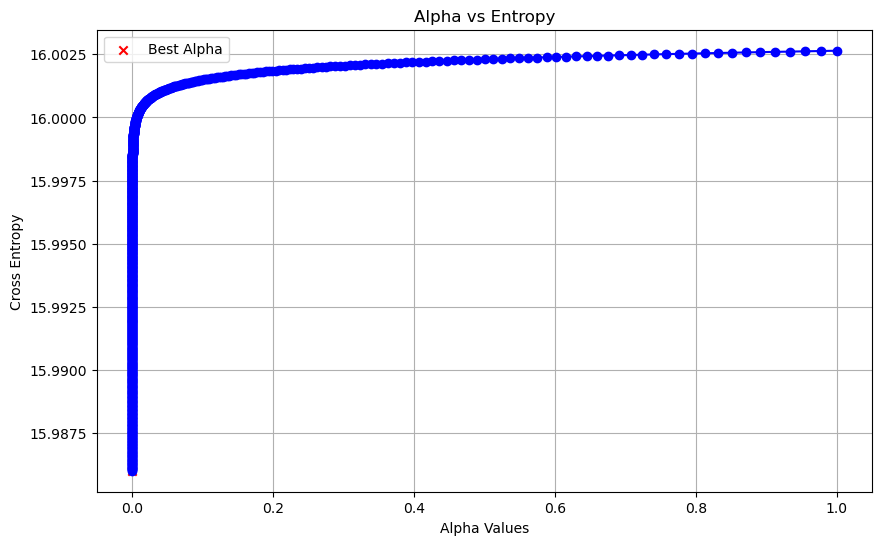

Optimal alpha (linear interpolation model):  1e-10


In [27]:
li_model = LinearInterpolationModel(alpha=0.01, lamda=0.5)
li_model.fit(train_corpus)
li_opt_alpha = ngram_model_alpha_search(li_model, np.logspace(-10, 0, 1000), development_set)

print("Optimal alpha (linear interpolation model): ", li_opt_alpha)

Now, let's test the performance in the test set, after having defined the optimal alpha.

In [28]:
# since la place smoothing is only involved during inference
# we don't need to refit the model
bi_model.alpha = bi_opt_alpha

bi_hc = cross_entropy(bi_model, test_set)
print(f"Bi-gram model Cross Entropy: {bi_hc:.2f}", )
print(f"Bi-gram model Perplexity: {perplexity(bi_hc):2f}")

Bi-gram model Cross Entropy: 9.01
Bi-gram model Perplexity: 516.548109


In [29]:
tri_model.alpha = tri_opt_alpha

tri_hc = cross_entropy(tri_model, test_set)
print(f"Tri-gram model Cross Entropy: {tri_hc:.2f}")
print(f"Tri-gram model Perplexity: {perplexity(tri_hc):.2f}")

Tri-gram model Cross Entropy: 9.17
Tri-gram model Perplexity: 575.57


v. Create a fake dataset

In [30]:
import random


def corrupt_sentence(sentence, probability):
    corrupted_sentence = ""
    for char in sentence:
        if char != ' ' and random.random() < probability:
            
            corrupted_sentence += get_similar_char(char)                 #replace with a similar character
        else:
            corrupted_sentence += char
    return corrupted_sentence


def get_similar_char(char):
    # later on maybe use the nlpaug library here 
    similar_chars = {
        'a': 'e',
        'b': 'p',
        'c': 's',
        'd': 'b',
        'e': 'a',
        'f': 't',
        'g': 'j',
        'h': 'n',
        'i': 'l',
        'j': 'g',
        'k': 'x',
        'l': 'i',
        'm': 'n',
        'n': 'm',
        'o': 'u',
        'p': 'b',
        'q': 'g',
        'r': 't',
        's': 'c',
        't': 'f',
        'u': 'o',
        'v': 'w',
        'w': 'v',
        'x': 'k',
        'y': 'v',
        'z': 's',
    }
    
    return similar_chars.get(char, char)                            #return a randomly chosen character

In [31]:
probability = 0.2                                        #probability of character replacement
corrupted_corpus = [[corrupt_sentence(word, probability) for word in sentence] for sentence in UNK_sentences]   #generate the corrupted corpus
corrupted_tokenized = [tweet_wt.tokenize(sentence) for sentence_list in corrupted_corpus for sentence in sentence_list] #tokenize the corrupted sentences

for original, corrupted in zip(UNK_sentences[:5], corrupted_corpus[:5]):
    print(f"Original: {original}")
    print(f"Corrupted: {corrupted}")
    print("\n---\n")

Original: ['He is very old and very wise .']
Corrupted: ['Ha is very oid and vety wlsa .']

---

Original: ['it is also a <UNK> as one parents can watch , and enjoy along with their kids .']
Corrupted: ['it is aiso a <UNK> as ona baremfc can watch , and enjov aionj vitn fneir klds .']

---

Original: ['as ghost dog <UNK> through his world , his life is touched by two people .']
Corrupted: ['as gnosf bog <UNK> tnrough his wotld , his life is tuoched by two people .']

---

Original: ['the gorgeous scenery of <UNK> town <UNK> and sparkling <UNK> provides a perfect love story backdrop -- you just might want to ask the attractive stranger in the seat behind you for coffee after the lights come up .']
Corrupted: ['fha gorgeous ssenery uf <UNK> towm <UNK> anb sparkling <UNK> pruvidas a perfect lova story backdrup -- vou gost might wamt to ack the aftrasfiwe stranger ln tha ceat behind yoo for soffee after the lijhts cone up .']

---

Original: ['this role is in painful contrast with the stro

In [32]:
import jiwer


def calculate_wer_cer(original_sentences, corrected_sentences):
    wer_sum = 0
    cer_sum = 0
    total_sentences = len(original_sentences)

    for original, corrected in zip(original_sentences, corrected_sentences):
        wer = jiwer.wer(original, corrected)
        
        wer_sum += wer

        
        cer = jiwer.cer(original, corrected)
        cer_sum += cer

    
    avg_wer = wer_sum / total_sentences
    avg_cer = cer_sum / total_sentences

    return avg_wer, avg_cer

In [33]:
# how many sentences to be used for the spell correct models
to_correct_num = 50

In [34]:
bi_corrected = []
corrector = BigramSpellCorrector(bi_model, lamda=0.1)

print(f"Bigram model: Computing correct sentences for {to_correct_num} sentences")
for sent in tqdm(corrupted_tokenized[:to_correct_num]):
    output_seq = corrector.spell_correct(original_tokenized_sentence=sent, beam_width = 3)  #give the corrupt sentences to spell correct
    bi_corrected.append(output_seq)

# made one print so it is visualized better
print('Sample original sentence:', UNK_sentences[0])
print('\n')
print('Corrupted(wrong) sentence:', corrupted_corpus[0])
print('\n')
print('Final bi-gram result (corrected sentence):', " ".join(bi_corrected[0]))

Bigram model: Computing correct sentences for 50 sentences


  0%|          | 0/50 [00:00<?, ?it/s]

Sample original sentence: ['He is very old and very wise .']


Corrupted(wrong) sentence: ['Ha is very oid and vety wlsa .']


Final bi-gram result (corrected sentence): He is very old and very well .


In [35]:
avg_wer, avg_cer = calculate_wer_cer(tokenized, bi_corrected)

print(f"Bigram Average Word Error Rate (WER): {avg_wer:.3f}")
print(f"Bigram Average Character Error Rate (CER): {avg_cer:.3f}")

ValueError: After applying the transforms on the reference and hypothesis sentences, their lengths must match. Instead got 8 reference and 6 hypothesis sentences.

In [ ]:
tri_corrected = []
corrector = TrigramSpellCorrector(tri_model, lamda=0.1)

print(f"Trigram model: Computing correct sentences for {to_correct_num} sentences")
for sent in tqdm(corrupted_tokenized[:50]):
    output_seq = corrector.spell_correct(original_tokenized_sentence=sent, beam_width = 3)  #give the corrupt sentences to spell correct
    tri_corrected.append(output_seq)
    
print('Sample original sentence:', UNK_sentences[0])
print('\n')
print('Corrupted(wrong) sentence:', corrupted_corpus[0])
print('\n')
print('Final tri-gram result (corrected sentences):', " ".join(tri_corrected[0]))

In [ ]:
avg_wer, avg_cer = calculate_wer_cer(tokenized, tri_corrected)

# im looking into this
print(f"Trigram Average Word Error Rate (WER): {avg_wer}")
print(f"Trigram Average Character Error Rate (CER): {avg_cer}")